In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
from datasets import Dataset
from transformers import AutoTokenizer, AutoModel
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from IPython.display import display

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA RTX A6000


In [2]:
# --- 2. 設定 ---

# 最終版のクリーニング済みデータ
TRAINING_FILE = "data/processed/training_dataset_hard_negatives_specter2.csv"

# ▼▼▼ 修正点: 事前学習済みモデルを使用 ▼▼▼
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"

# 推論（Embedding）時のバッチサイズ
# (GPUメモリが許す限り大きくすると高速になります)
INFERENCE_BATCH_SIZE = 256 
MAX_LENGTH = 512

print("Configuration set for Pre-trained Similarity Analysis.")

Configuration set for Pre-trained Similarity Analysis.


In [3]:
# --- 3. 事前学習済みモデルとトークナイザのロード ---

print(f"Loading tokenizer: {MODEL_CHECKPOINT}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

print(f"Loading PRE-TRAINED model: {MODEL_CHECKPOINT}")
# ▼▼▼ 修正点: AutoModelを使用 (分類ヘッドのない、生のBERT) ▼▼▼
model = AutoModel.from_pretrained(MODEL_CHECKPOINT).to(device)
model.eval() # 評価モードに設定
print("Model and tokenizer loaded successfully.")

Loading tokenizer: allenai/scibert_scivocab_uncased


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading PRE-TRAINED model: allenai/scibert_scivocab_uncased
Model and tokenizer loaded successfully.


In [4]:
# --- 4. データセットの読み込み ---
print(f"Loading dataset: {TRAINING_FILE}")
df = pd.read_csv(TRAINING_FILE)
df = df.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df['label'] = df['label'].astype(int)
print(f"Loaded {len(df)} pairs.")

# Hugging Face Datasets形式に変換
dataset = Dataset.from_pandas(df)

Loading dataset: data/processed/training_dataset_hard_negatives_specter2.csv
Loaded 28052 pairs.


In [5]:
# --- 5. Embedding（ベクトル化）関数の定義 ---

def get_cls_embeddings(batch_texts):
    """
    テキストのバッチを受け取り、
    事前学習済みSciBERTのCLSトークンベクトルを返す
    """
    # トークナイズ
    inputs = tokenizer(
        batch_texts, 
        padding="max_length", 
        truncation=True, 
        max_length=MAX_LENGTH, 
        return_tensors="pt"
    ).to(device)
    
    # 勾配計算を無効にして推論
    with torch.no_grad():
        outputs = model(**inputs)
    
    # CLSプーリング（実験計画書と一致）
    cls_embeddings = outputs.pooler_output
    
    # GPUからCPUに戻す
    return cls_embeddings.cpu().numpy()

print("Embedding function defined.")

Embedding function defined.


In [6]:
# --- 6. 全ペアのベクトル化と類似度計算 ---

print("Calculating embeddings for 'abstract_a'...")
vecs_a = dataset.map(
    lambda batch: {'vec_a': get_cls_embeddings(batch['abstract_a'])},
    batched=True,
    batch_size=INFERENCE_BATCH_SIZE
)['vec_a']

print("Calculating embeddings for 'abstract_b'...")
vecs_b = dataset.map(
    lambda batch: {'vec_b': get_cls_embeddings(batch['abstract_b'])},
    batched=True,
    batch_size=INFERENCE_BATCH_SIZE
)['vec_b']

print("Calculating cosine similarity...")
# 高速な計算のため、Numpy配列からTorchテンソルに変換
vecs_a_tensor = torch.tensor(np.array(vecs_a))
vecs_b_tensor = torch.tensor(np.array(vecs_b))

# コサイン類似度を計算
cos_sim = F.cosine_similarity(vecs_a_tensor, vecs_b_tensor, dim=1)

# 元のDataFrameに類似度とラベルを追加
df_results = pd.DataFrame({
    'cosine_similarity': cos_sim.numpy(),
    'label': dataset['label']
})

print("Analysis complete.")
display(df_results.head())

Calculating embeddings for 'abstract_a'...


Map:   0%|          | 0/28052 [00:00<?, ? examples/s]

Calculating embeddings for 'abstract_b'...


Map:   0%|          | 0/28052 [00:00<?, ? examples/s]

Calculating cosine similarity...
Analysis complete.


,cosine_similarity,label
0,0.589860,1
1,0.585003,0
2,0.638294,0
3,0.632822,0
4,0.674638,1



--- Visualization 1: Positive vs. Negative Distribution ---


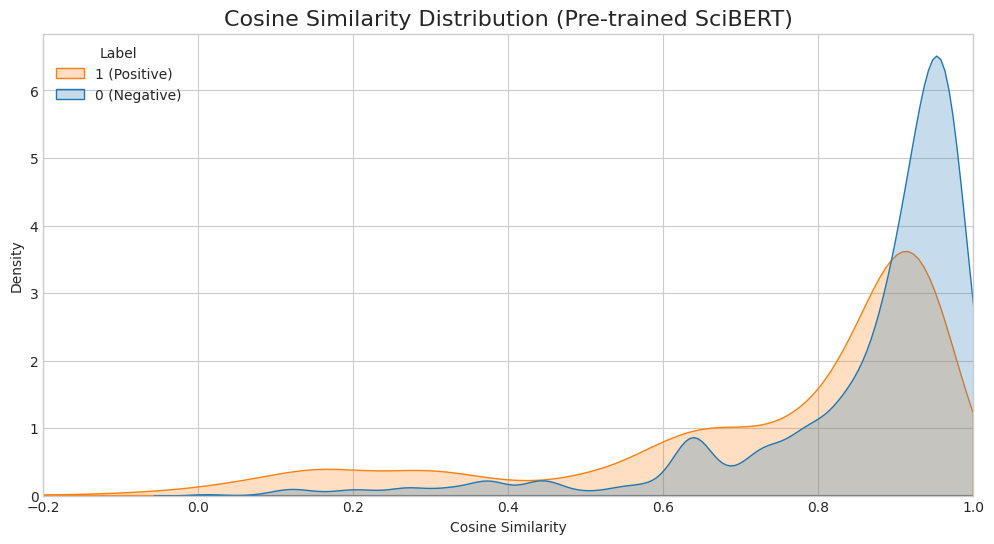


--- Statistics ---
Positive Pairs (label=1):


count    7013.000000
mean        0.737488
std         0.253758
min        -0.270415
25%         0.642839
50%         0.848006
75%         0.918669
max         1.000000
Name: cosine_similarity, dtype: float64


Negative Pairs (label=0):


count    21039.000000
mean         0.858266
std          0.166562
min          0.010599
25%          0.833529
50%          0.920789
75%          0.959166
max          1.000000
Name: cosine_similarity, dtype: float64

In [7]:
# --- 7. 可視化1: 正例と負例の分布の比較 ---
print("\n--- Visualization 1: Positive vs. Negative Distribution ---")

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# hue='label' を使うことで、ラベル(0/1)ごとに色分けされたKDEプロット（カーネル密度推定）を描画
sns.kdeplot(
    data=df_results, 
    x='cosine_similarity', 
    hue='label', 
    fill=True, 
    common_norm=False, # 0と1のカウント数が違っても面積が同じにならないようにする
    clip=(-1.0, 1.0),
)

plt.title('Cosine Similarity Distribution (Pre-trained SciBERT)', fontsize=16)
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.xlim(-0.2, 1.0)
plt.legend(title='Label', labels=['1 (Positive)', '0 (Negative)'])
plt.show()

print("\n--- Statistics ---")
print("Positive Pairs (label=1):")
display(df_results[df_results['label']==1]['cosine_similarity'].describe())
print("\nNegative Pairs (label=0):")
display(df_results[df_results['label']==0]['cosine_similarity'].describe())